## Downtask: News classification

# 1.Marathi

In [1]:
!pip install indic-nlp-library
!pip install pandas pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 50.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.7/92.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 6.3 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

cuda_available = torch.cuda.is_available()
print("CUDA Available:", cuda_available)
device = torch.device("cuda" if cuda_available else "cpu")

CUDA Available: True


In [3]:
class ELMoLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(ELMoLanguageModel, self).__init__()
        self.forward_lstm1 = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.forward_lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers=1, batch_first=True)
        self.backward_lstm1 = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.backward_lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers=1, batch_first=True)

        self.forward_pred = nn.Linear(hidden_dim, vocab_size)
        self.backward_pred = nn.Linear(hidden_dim, vocab_size)
        self.gamma = nn.Parameter(torch.ones(3))  
        self.freeze_parameters()
        
    def freeze_parameters(self):
        for name, param in self.named_parameters():
            if 'gamma' not in name:
                param.requires_grad = False

    def forward(self, x):
        
        forward_out1, _ = self.forward_lstm1(x)
        forward_out2, _ = self.forward_lstm2(forward_out1)

        
        reversed_embeddings = torch.flip(x, [1])
        backward_out1, _ = self.backward_lstm1(reversed_embeddings)
        backward_out2, _ = self.backward_lstm2(backward_out1)

        backward_out1 = torch.flip(backward_out1, [1])
        backward_out2 = torch.flip(backward_out2, [1])

        forward_predictions = self.forward_pred(forward_out2[:, -1, :])
        backward_predictions = self.backward_pred(backward_out2[:, 0, :])

        combined_embeddings = self.gamma[0] * x + self.gamma[1] * torch.cat((forward_out1, backward_out1), dim=-1) + self.gamma[2] * torch.cat((forward_out2, backward_out2), dim=-1)

        return forward_predictions, backward_predictions, combined_embeddings


In [4]:
import json
import torch

def load_model_and_mappings(model_path, mappings_path):
    with open(mappings_path, 'r', encoding='utf-8') as f:
        mappings = json.load(f)

    token_to_index = mappings['token_to_index']
    vocab_size = len(token_to_index) + 1 
    model = ELMoLanguageModel(vocab_size, 300, 150).to(device)
    
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()  
    
    return model, token_to_index


model_path = '/kaggle/input/final-elmo-model/bilm_marathi_model (1).pth'
mappings_path = '/kaggle/input/final-elmo-model/marathi_mappings.json'

model, token_to_index = load_model_and_mappings(model_path, mappings_path)

In [5]:
import os
import re
from indicnlp.tokenize import indic_tokenize

def preprocess_text(text, language='mr'):
    
    text = remove_non_textual_elements(text)
    text = normalize_quotation_marks(text)
    text = ensure_utf8_encoding(text)
    sentences = tokenize_sentences(text)
    sentences_SOS = ["<SOS> "+sentence+" <EOS>" for sentence in sentences]
    tokenized_sentences = [tokenize_words_indicnlp(sentence, language) for sentence in sentences_SOS]
    return ' '.join([' '.join(sentence) for sentence in tokenized_sentences])

def remove_non_textual_elements(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def normalize_quotation_marks(text):
    text = text.replace('“', '"').replace('”', '"')
    text = text.replace("‘", "'").replace("’", "'")
    return text

def ensure_utf8_encoding(text):
    return text.encode('utf-8', errors='ignore').decode('utf-8')

def tokenize_sentences(text):
    sentences = re.split(r'[।\n\.]+', text)
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    return sentences

def tokenize_words_indicnlp(sentence, language='mr'):
    return indic_tokenize.trivial_tokenize(sentence, lang=language)


In [6]:
import pandas as pd
import fasttext
import fasttext.util

ft_model = fasttext.load_model('/kaggle/input/pre-trained-model-indicft/indicnlp.ft.mr.300.bin')

def load_dataset(parquet_path):
    
    return pd.read_parquet(parquet_path)

train_path = '/kaggle/input/news-category-classification/marathi/train-00000-of-00001.parquet'
test_path = '/kaggle/input/news-category-classification/marathi/test-00000-of-00001.parquet'
val_path = '/kaggle/input/news-category-classification/marathi/validation-00000-of-00001.parquet'

train_df = load_dataset(train_path)
test_df = load_dataset(test_path)
val_df = load_dataset(val_path)

print("Train Dataset:", train_df.head())
print("Test Dataset:", test_df.head())
print("Validation Dataset:", val_df.head())

Train Dataset:                                                 text  label
0           …म्हणून सानिया मिर्झाची ड्यू डेट आहे खास      0
1  Video : दीपिका-रणवीरच्या लग्नाचा मेन्यू झाला लीक!      0
2   सचिनच्या रणजी कारकीर्दीचा शेवट गोड, मुंबईचा विजय      3
3  पुरंदरेंना महाराष्ट्र भूषण पुरस्काराविरोधात सं...      4
4  जयपूर पोलिसांच्या जाहिरातीवर बुमराह संतापला, स...      3
Test Dataset:                                                 text  label
0  काजोल पुन्हा माझ्या आयुष्यात येणार नाही - करण ...      0
1             विराटला चीअर करण्यासाठी अनुष्का सिडनीत      0
2                                     संतोषचा अड्डा!      0
3  मुरूड समुद्रात बुडालेल्या विद्यार्थ्याचा मृतदे...      4
4  गोव्यात शिवसेना वेलिंगकरांसोबत,लवकरच युतीची घोषणा      4
Validation Dataset:                                                 text  label
0  CWG 2018 : संजिता चानूची सुवर्णभरारी, भारताच्य...      3
1  कर्मचार्‍यांच्या हलगर्जीपणामुळे होणार होते जिव...      4
2                श्रीलंकेचा भारतावर 7 गडी राखून विज

In [7]:
def preprocess_dataset(df, text_column='text'):
    df[text_column] = df[text_column].apply(lambda x: preprocess_text(x))
    return df

train_df_preprocessed = preprocess_dataset(train_df, 'text')
test_df_preprocessed = preprocess_dataset(test_df, 'text')
val_df_preprocessed = preprocess_dataset(val_df, 'text')

texts_train = train_df_preprocessed['text'].tolist()
texts_test = test_df_preprocessed['text'].tolist()
texts_val = val_df_preprocessed['text'].tolist()
labels_train = train_df_preprocessed['label'].tolist()
labels_test = test_df_preprocessed['label'].tolist()
labels_val = val_df_preprocessed['label'].tolist()

print(train_df_preprocessed.head())

                                                text  label
0  < SOS > …म्हणून सानिया मिर्झाची ड्यू डेट आहे ख...      0
1  < SOS > Video : दीपिका - रणवीरच्या लग्नाचा मेन...      0
2  < SOS > सचिनच्या रणजी कारकीर्दीचा शेवट गोड , म...      3
3  < SOS > पुरंदरेंना महाराष्ट्र भूषण पुरस्कारावि...      4
4  < SOS > जयपूर पोलिसांच्या जाहिरातीवर बुमराह सं...      3


### 1.1 Baseline

train_loss,█▄▂▁▁
train_loss,0.14777


Epoch 1/5: 100%|██████████| 303/303 [00:17<00:00, 17.75it/s]


Average Loss Epoch 1: 0.5008843278284907


Epoch 2/5: 100%|██████████| 303/303 [00:17<00:00, 17.79it/s]


Average Loss Epoch 2: 0.2097904111993293


Epoch 3/5: 100%|██████████| 303/303 [00:17<00:00, 17.72it/s]


Average Loss Epoch 3: 0.17420236013288742


Epoch 4/5: 100%|██████████| 303/303 [00:16<00:00, 18.06it/s]


Average Loss Epoch 4: 0.147133501523202


Epoch 5/5: 100%|██████████| 303/303 [00:16<00:00, 17.85it/s]


Average Loss Epoch 5: 0.13259627632397186
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2660
           1       0.98      0.90      0.94       984
           2       0.98      0.98      0.98      6028

    accuracy                           0.97      9672
   macro avg       0.97      0.95      0.96      9672
weighted avg       0.97      0.97      0.97      9672



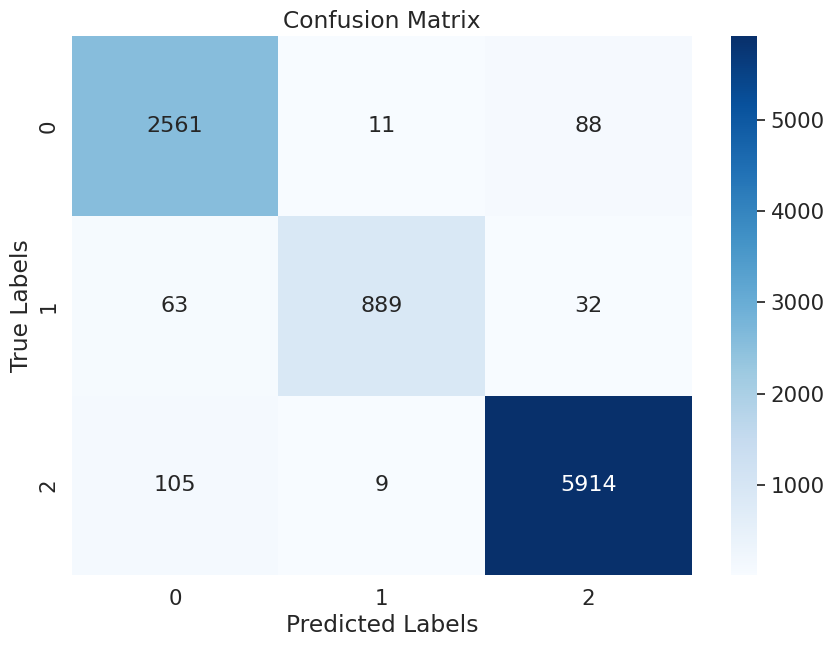

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
   


class MarathiDatasetCreate(Dataset):
    def __init__(self, texts, labels, ft_model, token_to_index, lang='mr'):
        self.texts = texts
        self.labels = labels
        self.ft_model = ft_model
        self.token_to_index = token_to_index
        self.lang = lang

        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(labels)

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        tokens = indic_tokenize.trivial_tokenize(text, lang=self.lang)
        embeddings = [self.ft_model.get_word_vector(token) for token in tokens]
        input_embeddings = torch.tensor(embeddings, dtype=torch.float)
        target_label = torch.tensor(label, dtype=torch.long)
        return input_embeddings, target_label

    def get_label_encoder(self):
        return self.label_encoder

def collate_fn(batch):
    inputs, labels = zip(*batch)
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0.0)
    labels = torch.tensor(labels, dtype=torch.long)
    return inputs_padded, labels

class BiLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=1, dropout=0.5):
        super(BiLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_outputs = lstm_out[:, -1, :]  
        output = self.fc(last_outputs)
        return output
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(token_to_index) 
hidden_dim = 150
input_dim = 300  
num_classes = len(set(train_df_preprocessed['label']))

elmo_model = ELMoLanguageModel(vocab_size, 300, hidden_dim).to(device)
classifier_baseline = BiLSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_baseline = torch.optim.Adam(classifier_baseline.parameters(), lr=0.001)

train_dataset = MarathiDatasetCreate(texts_train, labels_train, ft_model, token_to_index)
val_dataset = MarathiDatasetCreate(texts_val, labels_val, ft_model, token_to_index)
test_dataset = MarathiDatasetCreate(texts_test, labels_test, ft_model, token_to_index)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

wandb.init(project='ELMO_FOR_INDIAN_LANGUAGES_GROUP-30', name="Downtask1-Train_baseline_Marathi")


num_epochs = 5
for epoch in range(num_epochs):
    classifier_baseline.train()
    total_loss = 0

    for input_data, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        input_data, labels = input_data.to(device), labels.to(device)
        optimizer_baseline.zero_grad()

        outputs = classifier_baseline(input_data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_baseline.step()

        total_loss += loss.item()
    wandb.log({"train_loss": total_loss / len(train_loader)})
    print(f"Average Loss Epoch {epoch+1}: {total_loss / len(train_loader)}")

def extract_features_baseline(dataloader, classifier, device):
    classifier.eval()
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for input_data, labels in dataloader:
            input_data = input_data.to(device)
            outputs = classifier(input_data)
            all_embeddings.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_embeddings), np.array(all_labels)

train_embeddings, train_labels = extract_features_baseline(train_loader, classifier_baseline, device)
predicted_labels_train = np.argmax(train_embeddings, axis=1)

print(classification_report(train_labels, predicted_labels_train))

cm = confusion_matrix(train_labels, predicted_labels_train)

plt.figure(figsize=(10, 7))  
sns.set(font_scale=1.4)  
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap=plt.cm.Blues) 

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       335
           1       0.97      0.83      0.89       116
           2       0.95      0.97      0.96       759

    accuracy                           0.94      1210
   macro avg       0.94      0.90      0.92      1210
weighted avg       0.94      0.94      0.94      1210



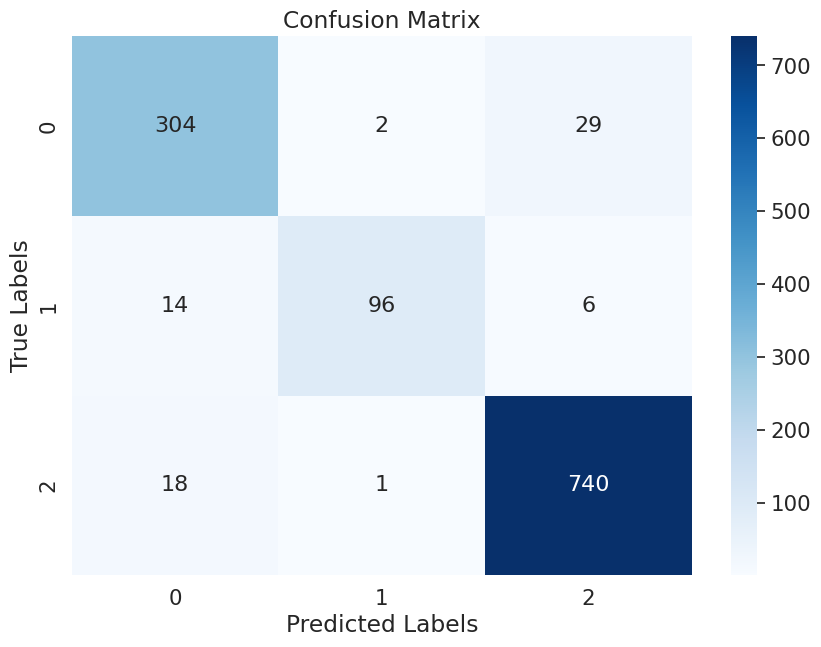

In [10]:
test_embeddings, test_labels = extract_features_baseline(test_loader, classifier_baseline, device)
predicted_labels = np.argmax(test_embeddings, axis=1)

print(classification_report(test_labels, predicted_labels))

cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 7))  
sns.set(font_scale=1.4)  
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap=plt.cm.Blues)  

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### 1.2 ELMO 

train_loss,█▂▂▁▁
train_loss,0.1326


Epoch 1/5: 100%|██████████| 303/303 [00:18<00:00, 16.16it/s]


Average Loss Epoch 1: 0.509461097689745


Epoch 2/5: 100%|██████████| 303/303 [00:18<00:00, 16.22it/s]


Average Loss Epoch 2: 0.24643194333653246


Epoch 3/5: 100%|██████████| 303/303 [00:18<00:00, 16.30it/s]


Average Loss Epoch 3: 0.1755633608471885


Epoch 4/5: 100%|██████████| 303/303 [00:18<00:00, 16.35it/s]


Average Loss Epoch 4: 0.15018428955227137


Epoch 5/5: 100%|██████████| 303/303 [00:18<00:00, 16.31it/s]


Average Loss Epoch 5: 0.12892595471402402
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      2660
           1       0.96      0.94      0.95       984
           2       0.96      0.99      0.98      6028

    accuracy                           0.96      9672
   macro avg       0.96      0.95      0.96      9672
weighted avg       0.96      0.96      0.96      9672



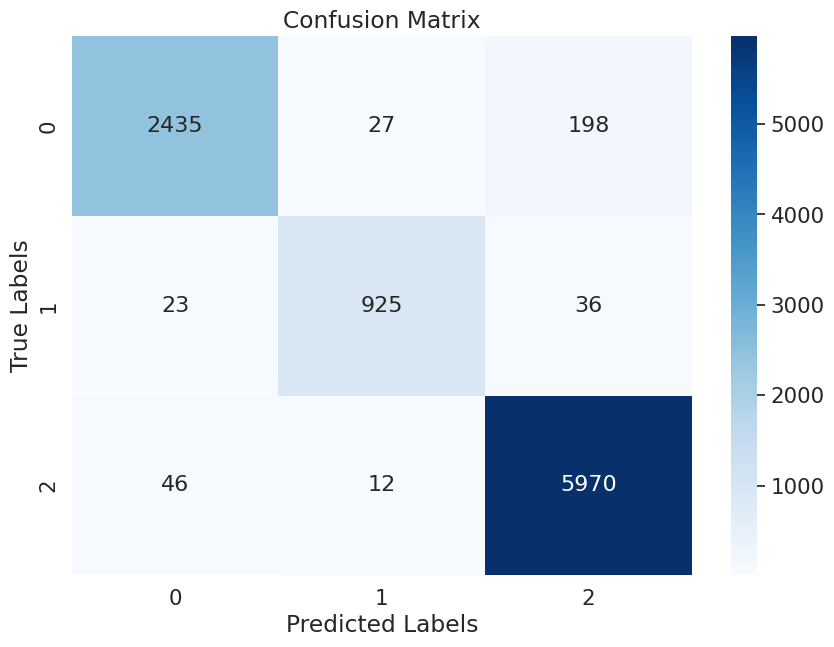

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import numpy as np

class MarathiDatasetCreate(Dataset):
    def __init__(self, texts, labels, ft_model, token_to_index, lang='mr'):
        self.texts = texts
        self.labels = labels
        self.ft_model = ft_model
        self.token_to_index = token_to_index
        self.lang = lang

        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(labels)

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        tokens = indic_tokenize.trivial_tokenize(text, lang=self.lang)
        embeddings = [self.ft_model.get_word_vector(token) for token in tokens]
        input_embeddings = torch.tensor(embeddings, dtype=torch.float)
        target_label = torch.tensor(label, dtype=torch.long)
        return input_embeddings, target_label

    def get_label_encoder(self):
        return self.label_encoder

def collate_fn(batch):
    inputs, labels = zip(*batch)
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0.0)
    labels = torch.tensor(labels, dtype=torch.long)
    return inputs_padded, labels

class BiLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=1, dropout=0.5):
        super(BiLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_outputs = lstm_out[:, -1, :]  
        output = self.fc(last_outputs)
        return output
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(token_to_index) 
hidden_dim = 150
input_dim = 300  
num_classes = len(set(train_df_preprocessed['label']))

elmo_model = ELMoLanguageModel(vocab_size, 300, hidden_dim).to(device)
classifier = BiLSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(elmo_model.parameters()) + list(classifier.parameters()), lr=0.001)

train_dataset = MarathiDatasetCreate(texts_train, labels_train, ft_model, token_to_index)
val_dataset = MarathiDatasetCreate(texts_val, labels_val, ft_model, token_to_index)
test_dataset = MarathiDatasetCreate(texts_test, labels_test, ft_model, token_to_index)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

wandb.init(project='ELMO_FOR_INDIAN_LANGUAGES_GROUP-30', name="Downtask1-Train_Elmo_Marathi")



num_epochs = 5
for epoch in range(num_epochs):
    elmo_model.train()
    classifier.train()
    total_loss = 0

    for input_data, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        input_data, labels = input_data.to(device), labels.to(device)
        optimizer.zero_grad()

        _, _, embeddings = elmo_model(input_data)

        outputs = classifier(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    wandb.log({"train_loss": total_loss / len(train_loader)})
    print(f"Average Loss Epoch {epoch+1}: {total_loss / len(train_loader)}")

def extract_features(dataloader, elmo_model, classifier, device):
    elmo_model.eval()
    classifier.eval()
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for input_data, labels in dataloader:
            input_data = input_data.to(device)
            _, _, embeddings = elmo_model(input_data)
            outputs = classifier(embeddings)
            all_embeddings.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_embeddings), np.array(all_labels)

train_embeddings, train_labels = extract_features(train_loader, elmo_model, classifier, device)
predicted_labels_train = np.argmax(train_embeddings, axis=1)

print(classification_report(train_labels, predicted_labels_train))

cm = confusion_matrix(train_labels, predicted_labels_train)
plt.figure(figsize=(10, 7))  
sns.set(font_scale=1.4)  
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap=plt.cm.Blues)  

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

              precision    recall  f1-score   support

           0       0.93      0.83      0.88       335
           1       0.89      0.83      0.86       116
           2       0.93      0.99      0.96       759

    accuracy                           0.93      1210
   macro avg       0.92      0.88      0.90      1210
weighted avg       0.93      0.93      0.93      1210



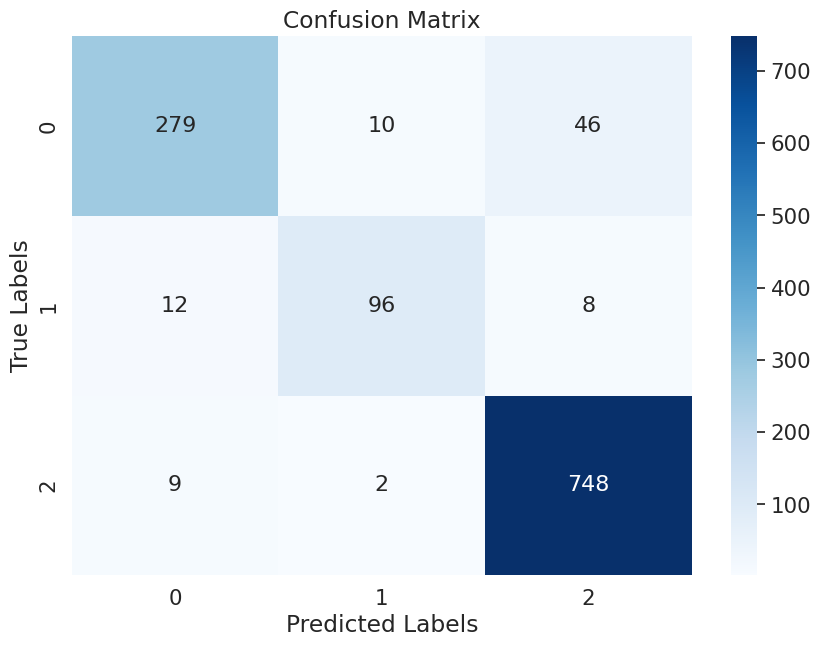

In [12]:
test_embeddings, test_labels = extract_features(test_loader, elmo_model, classifier, device)
predicted_labels = np.argmax(test_embeddings, axis=1)

print(classification_report(test_labels, predicted_labels))

cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 7))  
sns.set(font_scale=1.4)  
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap=plt.cm.Blues)  

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()